In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np 
from bias_utils import *


import constants as c 
import helpers as h 
from logger import setup_logger 
log = setup_logger("311-biases")
log.setLevel("INFO")
log.info("Modules loaded.")

h.latex(True)

2025-02-05 22:41:45 - 311-biases - INFO - Modules loaded.
2025-02-05 22:41:45 - analysis-helpers - INFO - Enabling LaTeX for matplotlib.


In [146]:
analysis_df = pd.read_csv(c.CURRENT_DF)
anlaysis_df = h.add_helper_cols(analysis_df)

2025-02-05 22:41:45 - analysis-helpers - INFO - Found 192 tracts with at least one FloodNet sensor.
2025-02-05 22:41:45 - analysis-helpers - INFO - Found 2171 311 requests.
2025-02-05 22:41:45 - analysis-helpers - INFO - Found 878 tracts with at least one 311 report.
2025-02-05 22:41:45 - analysis-helpers - INFO - Found 1001 tracts with no DEP flooding.


In [147]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   BoroName                                      2325 non-null   object 
 1   BoroCT2020                                    2325 non-null   int64  
 2   NTAName                                       2325 non-null   object 
 3   CDTANAME                                      2325 non-null   object 
 4   PUMA                                          2325 non-null   int64  
 5   empirical_estimate_ct                         2319 non-null   float64
 6   p_y                                           2325 non-null   float64
 7   p_y_CI_lower                                  2325 non-null   float64
 8   p_y_CI_upper                                  2325 non-null   float64
 9   empirical_estimate_p_alop                     2319 non-null   f

# basic exploratory analysis

In [148]:
pd.set_option('display.max_columns', 500)
analysis_df['confirmed_flooded_image'] = analysis_df['at_least_one_positive_image_by_area'] == 1
analysis_df['p_y_percentile'] = analysis_df['p_y'].rank(pct=True) * 100
thres = analysis_df[analysis_df['confirmed_flooded_image']]['p_y'].quantile(0.25)
print(thres)

analysis_df['above_thres'] = analysis_df['p_y'] > thres


analysis_df['white_frac'] = analysis_df['nhl_white_alone'] / analysis_df['total_population'] 
analysis_df['black_frac'] = analysis_df['nhl_black_alone'] / analysis_df['total_population']
analysis_df['hispanic_frac'] = analysis_df['hispanic_alone'] / analysis_df['total_population']
analysis_df['asian_frac'] = analysis_df['nhl_asian_alone'] / analysis_df['total_population']

analysis_df.head()


0.006943781295086425


,BoroName,BoroCT2020,NTAName,CDTANAME,PUMA,empirical_estimate_ct,p_y,p_y_CI_lower,p_y_CI_upper,empirical_estimate_p_alop,at_least_one_positive_image_by_area,at_least_one_positive_image_by_area_CI_lower,at_least_one_positive_image_by_area_CI_upper,total_population,nhl_white_alone,nhl_black_alone,hispanic_alone,nhl_asian_alone,n_children,n_elderly,total_households,num_households_with_internet,num_households_with_smartphone,median_household_income,num_high_school_graduates,num_bachelors_degree,num_graduate_degree,num_limited_english_speaking_households,ft_elevation_min,ft_elevation_max,ft_elevation_mean,area,n_floodnet_sensors,dep_moderate_1_area,dep_moderate_1_frac,dep_moderate_2_area,dep_moderate_2_frac,GEOID,sewer_backup_311c,street_flooding_311c,catch_basin_clogged/flooding_311c,manhole_overflow_311c,highway_flooding_311c,any_sensors,n_311_reports,any_311_report,no_dep_flooding,confirmed_flooded_image,p_y_percentile,above_thres,white_frac,black_frac,hispanic_frac,asian_frac
0,Manhattan,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),4121,NaN,0.053544,1.680531e-309,1.000000,NaN,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,-666666666,0,0,0,0,0.0,19.0,8.157155,1.842847e+06,0.0,0.000000,0.000000,0.000000,0.000000,36061000100,0,0,0,0,0,False,0,False,True,False,97.935484,True,NaN,NaN,NaN,NaN
1,Manhattan,1000201,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.000000,0.000840,4.894745e-06,0.005778,0.000000,0.170082,0.001687,0.864570,2666,238,216,1747,400,1180,328,878,726,740,45582,324,120,130,155,5.0,37.0,20.221000,9.723125e+05,0.0,0.000000,0.000000,0.000000,0.000000,36061000201,0,0,0,0,0,False,0,False,True,False,30.752688,False,0.089272,0.081020,0.655289,0.150038
2,Manhattan,1000600,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.002203,0.009041,8.006037e-04,0.030372,0.002203,1.000000,1.000000,1.000000,10751,859,654,3301,5567,1292,3340,5191,3792,3773,25655,2074,1559,268,1777,0.0,41.0,17.414628,2.582706e+06,0.0,22123.775465,0.008566,28743.307693,0.011129,36061000600,0,1,0,0,0,False,1,True,False,True,91.010753,True,0.079900,0.060832,0.307041,0.517812
3,Manhattan,1001401,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.000000,0.000225,2.432554e-06,0.001518,0.000000,0.049730,0.000640,0.329357,3165,2224,85,314,251,393,1136,1648,1300,1287,89873,310,867,863,111,24.0,43.0,34.848340,1.006117e+06,0.0,0.000000,0.000000,0.000000,0.000000,36061001401,1,0,0,0,0,False,1,True,True,False,2.107527,False,0.702686,0.026856,0.099210,0.079305
4,Manhattan,1001402,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.000000,0.000312,4.590895e-06,0.001913,0.000000,0.149912,0.003259,0.743719,3286,881,250,860,1099,229,858,1733,1335,1452,46615,550,896,300,545,13.0,42.0,27.555402,1.226207e+06,0.0,3811.632650,0.003108,7439.195282,0.006067,36061001402,0,0,0,0,0,False,0,False,False,False,5.032258,False,0.268107,0.076080,0.261716,0.334449


In [149]:
# educational attainment 
analysis_df['frac_hs'] = analysis_df['num_high_school_graduates'] / analysis_df['total_population']
analysis_df['frac_bachelors'] = analysis_df['num_bachelors_degree'] / analysis_df['total_population']
analysis_df['frac_grad'] = analysis_df['num_graduate_degree'] / analysis_df['total_population']


# age 
analysis_df['frac_children'] = analysis_df['n_children'] / analysis_df['total_population']
analysis_df['frac_elderly']  = analysis_df['n_elderly'] / analysis_df['total_population']


In [150]:
# internet 
analysis_df['frac_internet'] = analysis_df['num_households_with_internet'] / analysis_df['total_households']
analysis_df['frac_smartphone'] = analysis_df['num_households_with_smartphone'] / analysis_df['total_households']

# english first language 
analysis_df['frac_limited_english'] = analysis_df['num_limited_english_speaking_households'] / analysis_df['total_households']


In [151]:
vars = ['white_frac', 'black_frac', 'hispanic_frac', 'asian_frac', 'median_household_income', 'frac_hs', 'frac_bachelors', 'frac_grad', 'frac_internet', 'frac_smartphone', 'frac_limited_english', 'frac_children', 'frac_elderly', 'total_population']


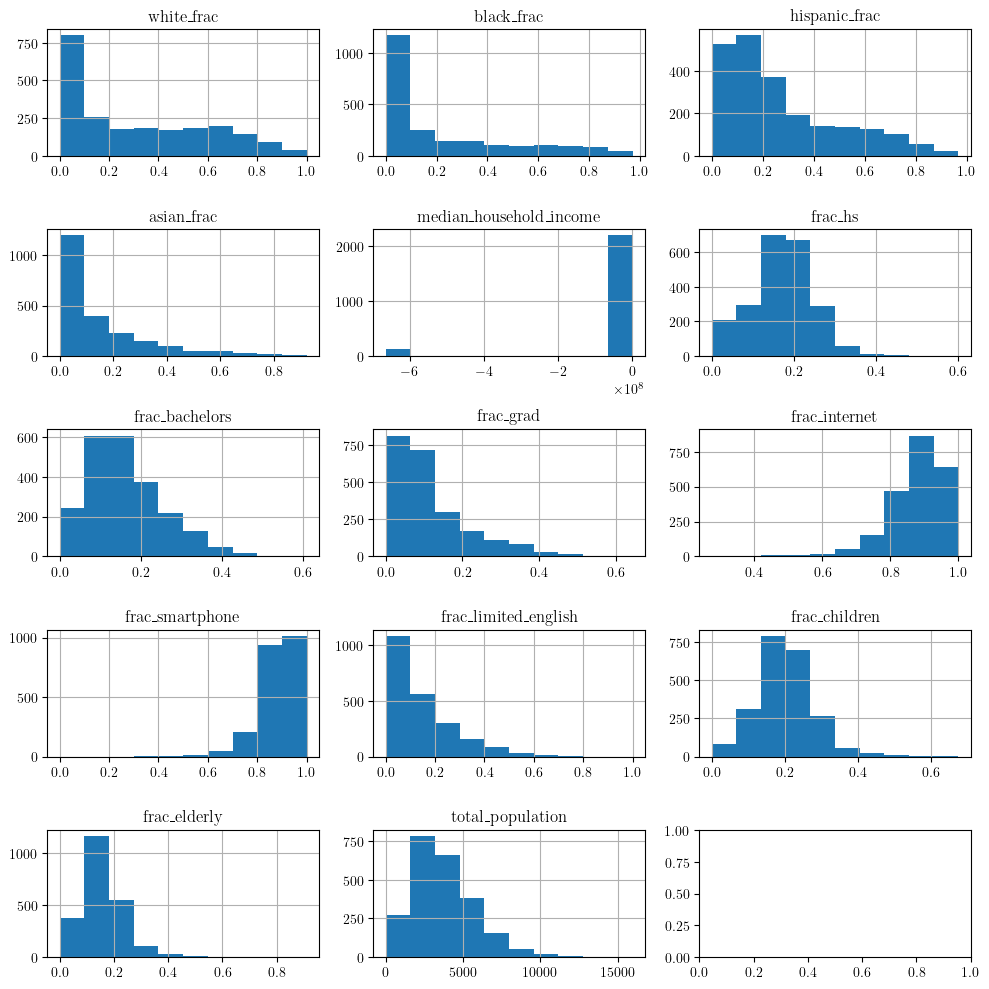

In [152]:
# make small histograms side by side for each var in vars 
fig, axs = plt.subplots(5, 3, figsize=(10, 10))
for i, var in enumerate(vars):
    ax = axs[i//3, i%3]
    analysis_df[var].hist(ax=ax)
    ax.set_title(var)
plt.tight_layout()



In [153]:
# log transform total_population 
# drop rows with 0 population 
analysis_df = analysis_df[analysis_df['total_population'] > 0]

analysis_df['total_population'] = np.log(analysis_df['total_population'])
# Add small constant to avoid log(0)
epsilon = 1e-10

# For each fraction, use log-ratio transformation
analysis_df['white_frac'] = np.log((analysis_df['white_frac'] + epsilon) / (1 - analysis_df['white_frac'] + epsilon))
analysis_df['black_frac'] = np.log((analysis_df['black_frac'] + epsilon) / (1 - analysis_df['black_frac'] + epsilon))
analysis_df['hispanic_frac'] = np.log((analysis_df['hispanic_frac'] + epsilon) / (1 - analysis_df['hispanic_frac'] + epsilon))
analysis_df['asian_frac'] = np.log((analysis_df['asian_frac'] + epsilon) / (1 - analysis_df['asian_frac'] + epsilon))

# log transform mhi 
analysis_df['median_household_income'] = np.log(analysis_df['median_household_income'])

# For total population, keep the log transform
analysis_df['total_population'] = np.log(analysis_df['total_population'])

epsilon = 1e-10  # small constant to handle 0s and 1s
analysis_df['frac_limited_english'] = np.log((analysis_df['frac_limited_english'] + epsilon) / 
                                            (1 - analysis_df['frac_limited_english'] + epsilon))
analysis_df['frac_grad'] = np.log((analysis_df['frac_grad'] + epsilon) / 
                                            (1 - analysis_df['frac_grad'] + epsilon))
anlaysis_df['frac_internet'] = np.log((analysis_df['frac_internet'] + epsilon) /
                                        (1 - analysis_df['frac_internet'] + epsilon))
analysis_df['frac_smartphone'] = np.log((analysis_df['frac_smartphone'] + epsilon) /
                                        (1 - analysis_df['frac_smartphone'] + epsilon))

/tmp/ipykernel_2563968/545139484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['total_population'] = np.log(analysis_df['total_population'])
/tmp/ipykernel_2563968/545139484.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['white_frac'] = np.log((analysis_df['white_frac'] + epsilon) / (1 - analysis_df['white_frac'] + epsilon))
/tmp/ipykernel_2563968/545139484.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [154]:
analysis_df['any_311_report'] = analysis_df['any_311_report'].astype(int)  


def get_bias_metrics(model, var):
    """
    Extract bias metrics from a fitted statsmodels model for a given variable.
    
    Parameters:
    -----------
    model : statsmodels.discrete.discrete_model.BinaryResultsWrapper
        Fitted logistic regression model
    var : str
        Name of the variable to extract metrics for
        
    Returns:
    --------
    pd.DataFrame
        Single row dataframe with metrics for the variable
    """
    params = model.params
    conf_int = model.conf_int()
    
    return pd.DataFrame({
        'variable': [var],
        'mean': [params[var]],
        'ci_lower': [conf_int.loc[var, 0]],
        'ci_upper': [conf_int.loc[var, 1]],
        'p_value': [model.pvalues[var]],
        'std_err': [model.bse[var]]
    })

def analyze_biases(data, outcome='any_311_report', predictor='p_y', 
                  variables=['white_frac', 'black_frac', 'hispanic_frac', 
                           'asian_frac', 'median_household_income', 'frac_hs', 'frac_bachelors', 'frac_grad', 'frac_internet', 'frac_smartphone', 'frac_limited_english']):
    """
    Analyze biases across multiple variables using logistic regression.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset
    outcome : str
        Name of binary outcome variable
    predictor : str
        Name of main predictor variable
    variables : list
        List of variables to analyze for bias
        
    Returns:
    --------
    pd.DataFrame
        Compiled bias metrics for all variables
    """
    bias_df = pd.DataFrame()
    
    for var in variables:
        # Standardize continuous variables
        data_std = data.copy()
        data_std[var] = (data_std[var] - data_std[var].mean()) / data_std[var].std()
        
        # Fit model with interaction
        formula = f'{outcome} ~ {predictor} + {var}'  # Simplified model without interaction
        try:
            model = sm.Logit.from_formula(formula, data=data_std).fit(
            )
            bias_metrics = get_bias_metrics(model, var)
            bias_df = pd.concat([bias_df, bias_metrics], ignore_index=True)
        except Exception as e:
            print(f"Error fitting model for {var}: {str(e)}")
            
    return bias_df

# Example usage:
# bias_results = analyze_biases(d_income)

bias_results = analyze_biases(analysis_df, outcome='any_311_report', variables=vars)



Optimization terminated successfully.
         Current function value: 0.654409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655346
  

/tmp/ipykernel_2563968/117952263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['any_311_report'] = analysis_df['any_311_report'].astype(int)


In [155]:
bias_results 

,variable,mean,ci_lower,ci_upper,p_value,std_err
0,white_frac,0.131136,0.037529,0.224743,0.006037,0.047760
1,black_frac,-0.019804,-0.104984,0.065376,0.648616,0.043460
2,hispanic_frac,-0.106857,-0.193543,-0.020171,0.015690,0.044228
3,asian_frac,0.062114,-0.025489,0.149717,0.164624,0.044696
4,median_household_income,0.161699,0.072957,0.250440,0.000355,0.045277
5,frac_hs,0.069028,-0.017084,0.155140,0.116154,0.043935
6,frac_bachelors,0.048245,-0.037353,0.133842,0.269296,0.043673
7,frac_grad,0.118038,0.019305,0.216771,0.019119,0.050375
8,frac_internet,0.056495,-0.030957,0.143948,0.205455,0.044619
9,frac_smartphone,-0.033930,-0.122166,0.054306,0.451041,0.045019


In [156]:
# replace variable names 
mapping = {
    'white_frac': 'Fraction White',
    'black_frac': 'Fraction Black',
    'hispanic_frac': 'Fraction Hispanic',
    'asian_frac': 'Fraction Asian',
    'median_household_income': 'Median Household Income',
    'frac_hs': 'Fraction High School Graduates',
    'frac_bachelors': 'Fraction Bachelor\'s Degree',
    'frac_grad': 'Fraction Graduate Degree',
    'frac_internet': 'Fraction Households with Internet',
    'frac_smartphone': 'Fraction Households with Smartphone',
    'frac_limited_english': 'Fraction Households with Limited English',
    'frac_children': r'Fraction Children ($<$ 18 yrs)',
    'frac_elderly': r'Fraction Elderly ( $\leq$ 65 years)',
    'total_population': 'Total Population',
}

bias_results['variable'] = bias_results['variable'].map(mapping)
bias_results = bias_results.set_index('variable')

In [157]:
bias_results

,mean,ci_lower,ci_upper,p_value,std_err
variable,,,,,
Fraction White,0.131136,0.037529,0.224743,0.006037,0.047760
Fraction Black,-0.019804,-0.104984,0.065376,0.648616,0.043460
Fraction Hispanic,-0.106857,-0.193543,-0.020171,0.015690,0.044228
Fraction Asian,0.062114,-0.025489,0.149717,0.164624,0.044696
Median Household Income,0.161699,0.072957,0.250440,0.000355,0.045277
Fraction High School Graduates,0.069028,-0.017084,0.155140,0.116154,0.043935
Fraction Bachelor's Degree,0.048245,-0.037353,0.133842,0.269296,0.043673
Fraction Graduate Degree,0.118038,0.019305,0.216771,0.019119,0.050375
Fraction Households with Internet,0.056495,-0.030957,0.143948,0.205455,0.044619


In [158]:
def plot_CIs_covariates(CIs_df, crop_plots=True, ax=None, figsize=(6, 6),
                        covariate_names=None, show=True, ylabel_size=12,
                        xlabel_size=12,
                        color_CIs_by_significance=True, fill_between=False, horizontal_lines=True):
    
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    
    CIs_df = CIs_df.replace({'-':np.nan}).dropna()
    if covariate_names is None: covariate_names = CIs_df.index.values
    
    estimates = CIs_df.loc[covariate_names, 'mean'].values
    UB = CIs_df.loc[covariate_names, 'ci_upper'].values
    LB = CIs_df.loc[covariate_names, 'ci_lower'].values
    CIs = np.vstack([estimates-LB, UB-estimates])
    
    # Get p-values from dataframe
    p_values = CIs_df['p_value'].values

    #Collect colors:
    if color_CIs_by_significance:
        colors = ['red' if ub < 0 else ('blue' if lb > 0 else 'grey')
                 for ub, lb in list(zip(UB, LB))]

        # color in if p-value is significant, else only color the edge 
        mfcs = ['none']*len(estimates)
        for i, p in enumerate(p_values):
            if p < 0.05:
                mfcs[i] = colors[i]
                
    else:
        colors = ['black']*len(estimates)

    #Plot:
    for estimate, name, CI, color, mfc, p_value in zip(estimates[::-1],
                                         covariate_names[::-1],
                                         CIs[::, ::-1].T,
                                         colors[::-1],
                                            mfcs[::-1],
                                         p_values[::-1]):
        _ = ax.errorbar(x=estimate,
                        y=name,
                        xerr=CI.reshape(2,1),
                        ecolor=color,
                        capsize=5,
                        linestyle='None',
                        linewidth=1.5,
                        marker="d",
                        markersize=5,
                        mfc=mfc,
                        mec=color)
        print(f"{name}: {estimate:.2f} ({CI[0]:.2f}, {CI[1]:.2f}). Significance: {p_value:.3f}")

    ax.tick_params(axis='y', labelsize=ylabel_size)
    ax.tick_params(axis='x', labelsize=xlabel_size)
    #Grids:
    xlim = ax.get_xlim()
    _ = ax.axvline(0, linestyle='--', color='black', alpha=0.75, zorder=-1, linewidth=1.)

    if fill_between:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), -0.5, 1.5, alpha=.4, color='lightgrey', linewidth=0)
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 6.5, 8.5, alpha=.4, color='lightgrey', linewidth=0)
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 10.5, 14.5, alpha=.4, color='lightgrey', linewidth=0)
    if horizontal_lines:
        for y, c in enumerate(colors[::-1]):
            _ = ax.hlines(y=y, xmin=-3, xmax=3, linestyle='--', linewidth=0.5, alpha=0.5, color='grey')
    _ = ax.set_xlim(xlim)
    _ = ax.set_ylim(-0.5, len(estimates)-0.5)
            
    if show: plt.show()
        
    return ax

In [159]:
bias_results

,mean,ci_lower,ci_upper,p_value,std_err
variable,,,,,
Fraction White,0.131136,0.037529,0.224743,0.006037,0.047760
Fraction Black,-0.019804,-0.104984,0.065376,0.648616,0.043460
Fraction Hispanic,-0.106857,-0.193543,-0.020171,0.015690,0.044228
Fraction Asian,0.062114,-0.025489,0.149717,0.164624,0.044696
Median Household Income,0.161699,0.072957,0.250440,0.000355,0.045277
Fraction High School Graduates,0.069028,-0.017084,0.155140,0.116154,0.043935
Fraction Bachelor's Degree,0.048245,-0.037353,0.133842,0.269296,0.043673
Fraction Graduate Degree,0.118038,0.019305,0.216771,0.019119,0.050375
Fraction Households with Internet,0.056495,-0.030957,0.143948,0.205455,0.044619


Total Population: 0.10 (0.09, 0.09). Significance: 0.034
Fraction Elderly ( $\leq$ 65 years): 0.01 (0.09, 0.09). Significance: 0.788
Fraction Children ($<$ 18 yrs): 0.09 (0.09, 0.09). Significance: 0.039
Fraction Households with Limited English: -0.01 (0.09, 0.09). Significance: 0.798
Fraction Households with Smartphone: -0.03 (0.09, 0.09). Significance: 0.451
Fraction Households with Internet: 0.06 (0.09, 0.09). Significance: 0.205
Fraction Graduate Degree: 0.12 (0.10, 0.10). Significance: 0.019
Fraction Bachelor's Degree: 0.05 (0.09, 0.09). Significance: 0.269
Fraction High School Graduates: 0.07 (0.09, 0.09). Significance: 0.116
Median Household Income: 0.16 (0.09, 0.09). Significance: 0.000
Fraction Asian: 0.06 (0.09, 0.09). Significance: 0.165
Fraction Hispanic: -0.11 (0.09, 0.09). Significance: 0.016
Fraction Black: -0.02 (0.09, 0.09). Significance: 0.649
Fraction White: 0.13 (0.09, 0.09). Significance: 0.006


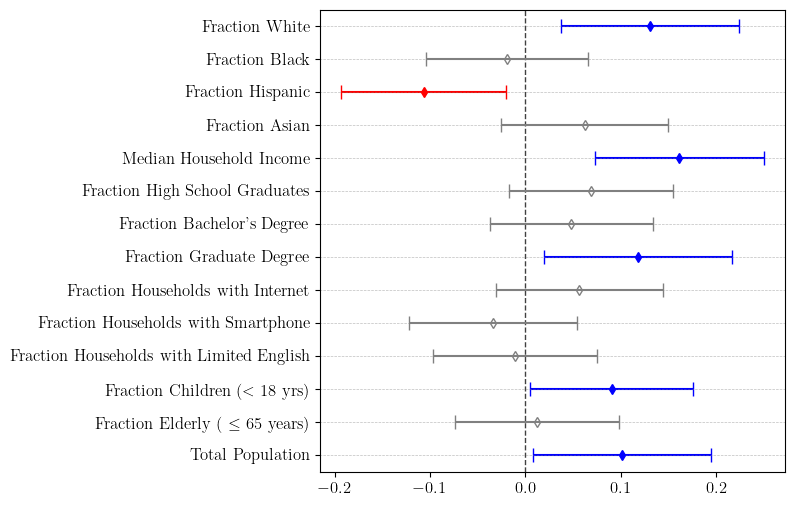

In [160]:
fig = plot_CIs_covariates(bias_results, show=False)
plt.savefig('../../KDD-2025-Matt-Flooding-Paper/figures/bias.pdf', bbox_inches='tight', dpi=300)
# save figure 

